# Viola77 EDA

This notebook contains several independent scripts that show how to load and visualize the dataset stats and annotated images:
- Section 1 shows the dataset stats
- Section 2 show the class hierarchical structure: super classes and classes
- Section 3 shows TACO images along with their segmentation masks

But first we need to load the annotations and some python libraries:

In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datasets import load_dataset, concatenate_datasets

Let's check the number of classes and length of the Viola77 dataset. It only contains 1 split: "train"

In [7]:
viola_dataset = load_dataset("viola77data/recycling-dataset", split="train")
classes = viola_dataset.features['label'].names
print(f"Available classes: {classes}")
len_dataset = len(viola_dataset)
print(f"Length Dataset: {len_dataset}")

Resolving data files:   0%|          | 0/3107 [00:00<?, ?it/s]

Available classes: ['aluminium', 'batteries', 'cardboard', 'disposable plates', 'glass', 'hard plastic', 'paper', 'paper towel', 'polystyrene', 'soft plastics', 'takeaway cups']
Length Dataset: 3107


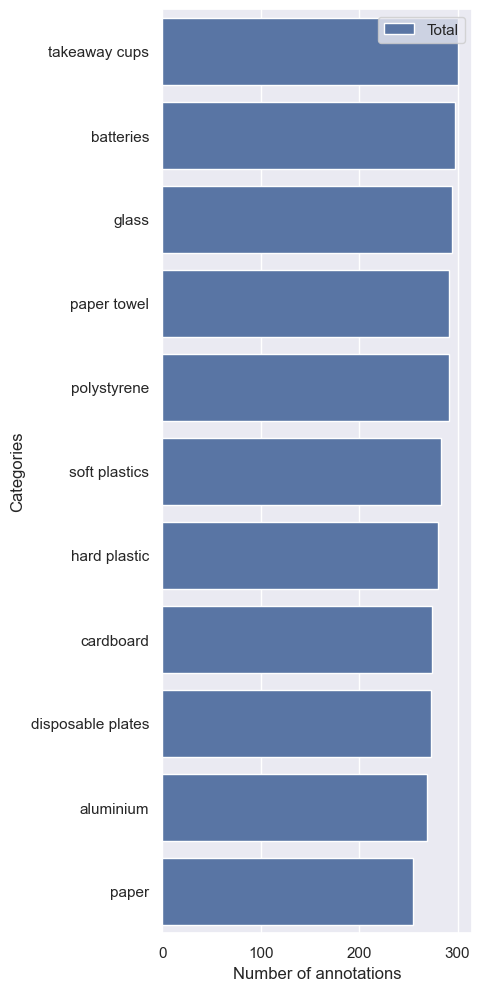

In [10]:
# Count annotations

cat_histogram = np.zeros(len(classes), dtype=int)
for element in viola_dataset:
    img, label = element.values()
    cat_histogram[label] += 1


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(4,12))

# Convert to DataFrame
df = pd.DataFrame({'Categories': classes, 'Number of annotations': cat_histogram})
df = df.sort_values(by='Number of annotations', axis=0, ascending=False)

# Plot the histogram
# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")

In [3]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch
from utilities.config_utils import TaskType
from custom_datasets.taco_dataset_vit import TacoDatasetViT
from custom_datasets.viola77_dataset import Viola77Dataset
from custom_datasets.taco_viola_dataset_vit import TacoViolaDatasetViT
# from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer
from torchvision.transforms import v2 as transforms
import os
from datasets import load_dataset, concatenate_datasets
from utilities.compute_metrics import create_compute_metrics
import numpy as np
import json

# Load the feature extractor and model
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Define data transforms
"""data_transforms_train = transforms.Compose([
    transforms.ToImage(),  # To tensor is deprecated
    transforms.ToDtype(torch.uint8, scale=True),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(0.5), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])"""
data_transforms_train = None

"""data_transforms_test = transforms.Compose([
    transforms.ToImage(),  # To tensor is deprecated,
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])"""
data_transforms_test = None

# Load the Viola dataset =================================================================
viola_dataset = load_dataset("viola77data/recycling-dataset", split="train")

# Split dataset into training, validation, and test sets
train_test_viola = viola_dataset.train_test_split(test_size=0.2)
val_test_viola = train_test_viola["test"].train_test_split(test_size=0.5)

train_dataset_viola = train_test_viola["train"]
val_dataset_viola = val_test_viola["train"]
test_dataset_viola = val_test_viola["test"]

# Create datasets with transforms
train_dataset_viola = Viola77Dataset(train_dataset_viola, transform=data_transforms_train)
val_dataset_viola = Viola77Dataset(val_dataset_viola, transform=data_transforms_test)
test_dataset_viola = Viola77Dataset(test_dataset_viola, transform=data_transforms_test)

# Obtain the categories form viola dataset
classes = viola_dataset.features['label'].names

# Load the TACO dataset =================================================================
train_annotations_file_taco = os.path.join("data", "train_annotations.json")
val_annotations_file_taco = os.path.join("data", "validation_annotations.json")
test_annotations_file_taco = os.path.join("data", "test_annotations.json")

# Prepare the mapping
with open("data/simplified_supercategories.json", "r") as f:
    categories_taco_viola = json.load(f)
mapping = { cat["id"]: cat["super_id"] for cat in categories_taco_viola }

# Create datasets with transforms
train_dataset_taco = TacoViolaDatasetViT(annotations_file=train_annotations_file_taco, img_dir="data/images", transform=data_transforms_train, classes=classes, mapping=mapping)
val_dataset_taco = TacoViolaDatasetViT(annotations_file=val_annotations_file_taco, img_dir="data/images", transform=data_transforms_test, classes=classes, mapping=mapping)
test_dataset_taco = TacoViolaDatasetViT(annotations_file=test_annotations_file_taco, img_dir="data/images", transform=data_transforms_test, classes=classes, mapping=mapping)

# Concatenate the datasets =================================================================
train_dataset = torch.utils.data.ConcatDataset([train_dataset_viola, train_dataset_taco])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_viola, val_dataset_taco])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_viola, test_dataset_taco])

# Get number of classes from dataset and the length
len_train_dataset = len(train_dataset)
len_val_dataset = len(val_dataset)
len_test_dataset = len(test_dataset)
num_classes = len(train_dataset_taco.idx_to_cluster_class)

# Get number of classes and label names from dataset
id2label = train_dataset_taco.idx_to_cluster_class
label2id = train_dataset_taco.cluster_class_to_idx

print(f"Number of anotations: {len_train_dataset+len_val_dataset+len_test_dataset} | Nr of categories: {num_classes}")

{0: 0, 1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 3, 7: 4, 8: 4, 9: 5, 10: 6, 11: 6, 12: 6, 13: 7, 14: 7, 15: 7, 16: 7, 17: 7, 18: 7, 19: 7, 20: 8, 21: 8, 22: 8, 23: 8, 24: 8, 25: 9, 26: 10, 27: 11, 28: 11, 29: 12, 30: 13, 31: 13, 32: 13, 33: 13, 34: 14, 35: 14, 36: 15, 37: 15, 38: 15, 39: 15, 40: 15, 41: 15, 42: 15, 43: 16, 44: 16, 45: 16, 46: 16, 47: 16, 48: 17, 49: 18, 50: 19, 51: 20, 52: 21, 53: 22, 54: 23, 55: 24, 56: 24, 57: 25, 58: 26, 59: 27}


Resolving data files:   0%|          | 0/3107 [00:00<?, ?it/s]

Available classes: ['aluminium', 'batteries', 'cardboard', 'disposable plates', 'glass', 'hard plastic', 'paper', 'paper towel', 'polystyrene', 'soft plastics', 'takeaway cups']
Cluster class to idx: {'aluminium': 0, 'batteries': 1, 'cardboard': 2, 'disposable plates': 3, 'glass': 4, 'hard plastic': 5, 'paper': 6, 'paper towel': 7, 'polystyrene': 8, 'soft plastics': 9, 'takeaway cups': 10}
Idx to cluster class: {0: 'aluminium', 1: 'batteries', 2: 'cardboard', 3: 'disposable plates', 4: 'glass', 5: 'hard plastic', 6: 'paper', 7: 'paper towel', 8: 'polystyrene', 9: 'soft plastics', 10: 'takeaway cups'}
Available classes: ['aluminium', 'batteries', 'cardboard', 'disposable plates', 'glass', 'hard plastic', 'paper', 'paper towel', 'polystyrene', 'soft plastics', 'takeaway cups']
Cluster class to idx: {'aluminium': 0, 'batteries': 1, 'cardboard': 2, 'disposable plates': 3, 'glass': 4, 'hard plastic': 5, 'paper': 6, 'paper towel': 7, 'polystyrene': 8, 'soft plastics': 9, 'takeaway cups': 10}

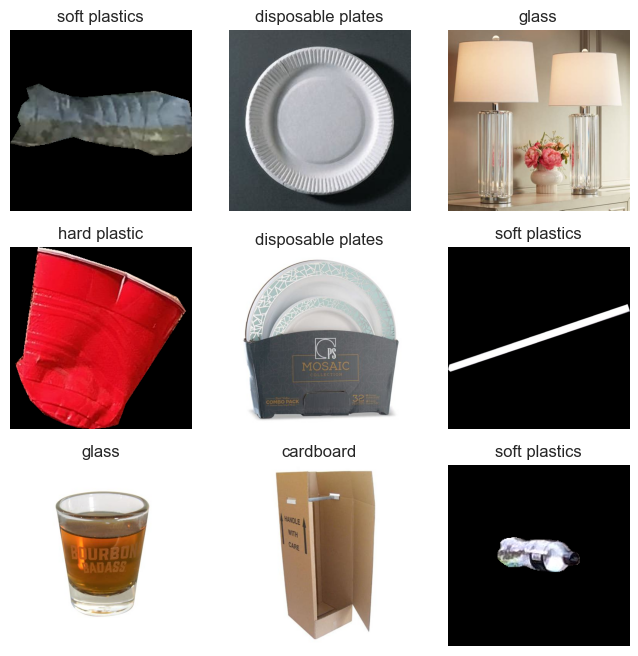

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):

    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    data = train_dataset[sample_idx]
    img, label = data.values()
    figure.add_subplot(rows, cols, i)
    plt.title(id2label[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

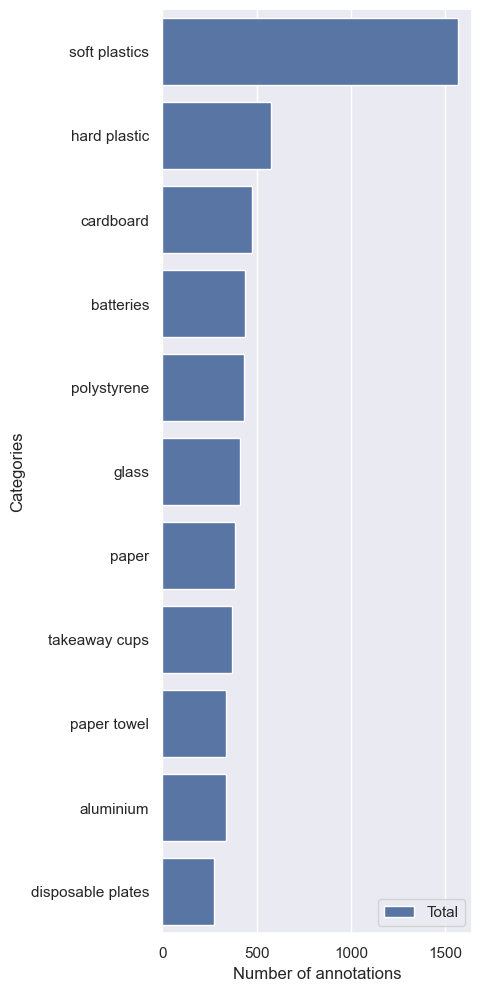

In [6]:
# Count annotations

cat_histogram = np.zeros(num_classes, dtype=int)
for element in train_dataset:
    img, label = element.values()
    cat_histogram[label] += 1

for element in val_dataset:
    img, label = element.values()
    cat_histogram[label] += 1

for element in test_dataset:
    img, label = element.values()
    cat_histogram[label] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(4,12))

# Convert to DataFrame
df = pd.DataFrame({'Categories': [value for value in id2label.values()], 'Number of annotations': cat_histogram})
df = df.sort_values(by='Number of annotations', axis=0, ascending=False)

# Plot the histogram
# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b")